## Description:
######Model type = LSTM
######Hidden layers = 128*2
######train seq_len = 150
######model id = lstm128-150


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [0]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Data Loading

In [3]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 150
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 15
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm128-150" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec.pkl"

Preprocessing Data

In [5]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)

576 torch.Size([151, 50])
29 torch.Size([151, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=250, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

Test Functionality

In [9]:
def test_model(cell_type="rnn", device='cpu'):
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cuda")
test_model("lstm", "cuda")

testing rnn model
test forward
torch.Size([151, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.02446666732430458
test generate with forwardc
JuliethtHzxRDGmNLNHcFgt-thXHzAHmFBxxZ$xtGYPBGIQPtStGa&KsxtGY-ODxtPGkb!JgtCJgKCTCJHQdgKoPBSNG3dXthXY$PtHgj&R
GGxxeGN.yHmAHmY-TdR
xR
Y-xw:$f$fGGxtGGxxR3wUYVxaCxRY M;K
SA-3dXYAHmY-xteFM;AHmAHcgbYh&thth thtHg'3wRY KSTthth tbH-xBZIxacFPGGtyHPf
YDGmArskbAHmAbmtb 

testing lstm model
test forward
torch.Size([151, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128]) torch.Size([2, 1, 128])
test cal_accuracy
0.007226666435599327
test generate with forwardc
Julietrjjjjjjjjjrjjjjjjjjjjjjjjjjjjjjjjjrjjjjjjjjjrjjjjjjjjjjjrjjjjjjjjjrjjjjjjjjrjjjjjjjjjrjjjjjjjjjjjjjjjjjrjjjjrjjjjjjjrjjjjjjjjrjjjjjjjjjjjjjjjjrjjjjrjjjjrjjjjjjjjjjjjjjjjjrjjjrjjjjjjjjjjrjjjjjjjjjjrjjjjjjjjjrjjjjjjrjjrjjjjjjjrjjjjrjjjjjjjjjjjjjjjjjjjj 



Train

Build new model

In [10]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train()
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            model.eval()
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [14]:
train()

  0%|          | 0/576 [00:00<?, ?it/s, loss=2.720, test_ac=0.279, train_ac=0.269]


At 1 epoche, loss = 3.228, train ac = 0.172, test ac = 0.170
RNN write with seed Juliet

##############################

Juliet co bnatl us threi, in nesd coy thol whuws toe, bye y, malls ohe pere cantsld, lnimoes wme tos cevl
her heo'x
O
OSeto no Got asee thoins puath atpera.

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=2.368, test_ac=0.338, train_ac=0.336]


At 2 epoche, loss = 2.495, train ac = 0.313, test ac = 0.312
RNN write with seed Juliet

##############################

Juliet fest uoe the le thneirn and cim,
hunl and fot the lkave cheaith,
an, be thet, pet wern hith all sohe me dalse
Kot haR w-mefeut wanle dale geveedd sin

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=2.234, test_ac=0.371, train_ac=0.369]


At 3 epoche, loss = 2.307, train ac = 0.350, test ac = 0.353
RNN write with seed Juliet

##############################

Julietom thou prowth shourt mashes worturl.

INLSUR:
Ir, wormink anlt in thith us fepwirs the cortheld the lorinter
Ferove the wy woust m of undismarals ant

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=2.099, test_ac=0.387, train_ac=0.400]


At 4 epoche, loss = 2.180, train ac = 0.377, test ac = 0.378
RNN write with seed Juliet

##############################

Juliet disger,
In me wirl the I mtanes:

OPERGUN:
Cings wery ungoot betred nech chellay of bose the deand.

IOIIT:
His if dermald hald with hit.

ARNHOS:
Na

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=2.118, test_ac=0.393, train_ac=0.381]


At 5 epoche, loss = 2.103, train ac = 0.394, test ac = 0.391
RNN write with seed Juliet

##############################

Juliet now thee had sour the rough in plome the till not to for deOrerbran thou wan frave and that he I pather:
Hrow me the nour a epger;
I the a have gooen

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=2.026, test_ac=0.407, train_ac=0.404]


At 6 epoche, loss = 2.078, train ac = 0.397, test ac = 0.403
RNN write with seed Juliet

##############################

Julieter seer as to of tullutped and all not at her came
best Cayed nower
I dean you thoust one;
I hall
The cuse her that wouble tirl of not corn cart his y

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.929, test_ac=0.422, train_ac=0.443]


At 7 epoche, loss = 2.010, train ac = 0.414, test ac = 0.419
RNN write with seed Juliet

##############################

Juliets and to lite on ich, the desent uganes this the colfer: whemsserdono steas ure serdernong,
And and huming,
Cirst a hame and all grak leven Say, wanti

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.989, test_ac=0.430, train_ac=0.424]


At 8 epoche, loss = 1.928, train ac = 0.437, test ac = 0.431
RNN write with seed Juliet

##############################

Juliet camp, to sofing homs carst,
If it with the ciunced in the moncwing me's thought, oo rage
Ilther he chath the cavent for oom;
Iw not no the reash nod 

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.955, test_ac=0.446, train_ac=0.426]


At 9 epoche, loss = 1.957, train ac = 0.425, test ac = 0.432
RNN write with seed Juliet

##############################

Julieted's fallike of the king to him somight one more
Everdine of that sAre the astins to wmangest, his will the say the kingerious
And frature is nene afp

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.884, test_ac=0.456, train_ac=0.452]


At 10 epoche, loss = 1.891, train ac = 0.441, test ac = 0.441
RNN write with seed Juliet

##############################

Juliet's of to net iinto: I cand it,
A laver the mador stole-cused in encrow love End taen a more.

IMON:
What fear am
Wook you and the womly beching Monose

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.898, test_ac=0.441, train_ac=0.436]


At 11 epoche, loss = 1.885, train ac = 0.447, test ac = 0.439
RNN write with seed Juliet

##############################

Julietle.

OSTAMLAN:
Cold.

NINTESTEST:
Becgarish see to make to the call,
The art is the beever ling I for the shalld their appart
And house that are on th

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.815, test_ac=0.434, train_ac=0.469]


At 12 epoche, loss = 1.852, train ac = 0.451, test ac = 0.449
RNN write with seed Juliet

##############################

Julietaon,
And as us my mear her agogh bless all emtire to my purpiwed scame, all as do your father the carsit here.

PANCINAN:
That shall your atself the p

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.789, test_ac=0.454, train_ac=0.463]


At 13 epoche, loss = 1.880, train ac = 0.447, test ac = 0.442
RNN write with seed Juliet

##############################

Juliet.

QAPLUDE:
Best the tramen to me shall would!

CARTADIUY:
I have Rome, we is god midity to my pach
with a mady agaous: shimpers not of thee errento,


##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.760, test_ac=0.454, train_ac=0.481]


At 14 epoche, loss = 1.803, train ac = 0.464, test ac = 0.457
RNN write with seed Juliet

##############################

Julietege, and laight
housned his the heaventer there
jus dencon a come her the son.

DUCENTER:
How marry he and good to miduselly.

Sleive:
O these lide, h

##############################



100%|██████████| 576/576 [00:11<00:00, 50.61it/s, loss=1.877, test_ac=0.459, train_ac=0.450]



At 15 epoche, loss = 1.830, train ac = 0.461, test ac = 0.451
RNN write with seed Juliet

##############################

Juliets. Ame, where of thy himon dost no have canlion
The this hime.

DOLDO FARTALIT:
Let you who waricition leave acespemss,
And camser the nother; and see

##############################

Tranning records saved to disk.


In [22]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.47059521079063416

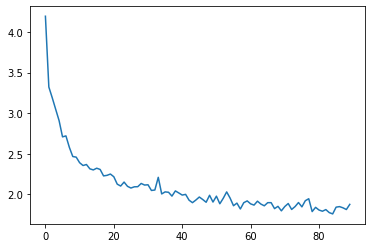

In [15]:
plt.figure()
plt.plot(record['loss'])
plt.show()

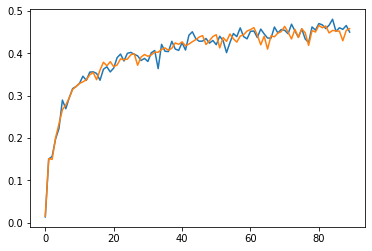

In [16]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [17]:
print(generate(model, device)) #default tau = 0.8

Julietion,
And and I this our that was the will compuly
And ever will, shall glent so of sourt
For high! there canst come in I gran spemore,
I be meny detlemiteas.

Cassing:
Which?

PRITHESTUR:
So hark like lest and me your conbetcented.

PRINGE HOMRINA:
A


In [18]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the  

julieturia, phowe; go'ksrs, flipk
Qenopl. By Wnatahte. mow noVour kcoGhy
Imocbany, a! charkFohd.

QMTERCALY:
Ournou'enn. Ile J: ithicks fegn. he!
Younsmy!
Haswec'd; Vurercprmwpcon in; toDvivoiPed
WJlea.
NaaniagarcD.H rese'T
Bife
que Gor, shim, lustiF,
Palb 



In [19]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i will doth.

HCRLICEST:
So that a none ily more her.

Frow Hegren:
Prost is not all the plarde; that
Not a have thou then me one; where and hercaits of to the worl
Same of your send it; peatle he is
In it of heather and slowrr as the cronger.

BUCIANA:
His pertine a truck fall in are the thaip
That bear thinkent cononted come we corainmen
Jou a part lains, for the now thee hours, have be of not tis
not see lords there she most my faurilt your art long.

HEGENA:
Well my love 'twight; becount that brig 



In [23]:
train()

  0%|          | 0/576 [00:00<?, ?it/s, loss=1.774, test_ac=0.458, train_ac=0.473]


At 1 epoche, loss = 1.777, train ac = 0.472, test ac = 0.455
RNN write with seed Juliet

##############################

Julieted chage,
A heart shall gove sweeat it will his best hem in that will man of the cray
To have you lady: the all is but it sack, sir and
and the stand.

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.775, test_ac=0.475, train_ac=0.469]


At 2 epoche, loss = 1.756, train ac = 0.479, test ac = 0.462
RNN write with seed Juliet

##############################

Julieter thee, whither worth?

VARISE:
I can how engerarn?

ORDINCLUS:
Any; in the benother, that the leove so know her by would.

CRASTIAN:
What the mortur

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.752, test_ac=0.477, train_ac=0.492]


At 3 epoche, loss = 1.771, train ac = 0.474, test ac = 0.467
RNN write with seed Juliet

##############################

Julietions of thee not one in the weld
To be dear the esterment of forth have be,
Thear the conture brouch thee bost of the pinight:
In have the report betr

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.660, test_ac=0.466, train_ac=0.503]


At 4 epoche, loss = 1.778, train ac = 0.473, test ac = 0.468
RNN write with seed Juliet

##############################

Julietion, the-kins of himber to a lovish,
And I in an thy trungly mate heart;
In eyes this of siltuch; and thou seet with so and
think what, and out of cre

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.704, test_ac=0.478, train_ac=0.487]


At 5 epoche, loss = 1.723, train ac = 0.489, test ac = 0.473
RNN write with seed Juliet

##############################

Julieter; my dear and
feeritue, you grieves: where shall be litter his thouse speakes like that slow hear 'case
What broud of this it brings a return but se

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.730, test_ac=0.461, train_ac=0.494]


At 6 epoche, loss = 1.720, train ac = 0.490, test ac = 0.481
RNN write with seed Juliet

##############################

Julieted me,
Strock may luars lond she we that thy connamus.

First Tade:
Coed the stoned, and your forest as the dangers!

HUMULE ENOFARD EDUS HENDERECR:
G

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.796, test_ac=0.489, train_ac=0.474]


At 7 epoche, loss = 1.700, train ac = 0.495, test ac = 0.482
RNN write with seed Juliet

##############################

Juliet it this fear
Why'ld a kinds he wise mead, and hence
That he vilust mother, thou prittous and munce;
And have be the margient his compadeacy of an
Can

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.733, test_ac=0.449, train_ac=0.487]


At 8 epoche, loss = 1.714, train ac = 0.495, test ac = 0.486
RNN write with seed Juliet

##############################

Juliety to with had disprait.

KING HENRY:
If the foul some men, I man deased,
I will not bid your lords.

POCTIFES:
Nay, do be, I confarughing of my earth


##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.684, test_ac=0.483, train_ac=0.489]


At 9 epoche, loss = 1.700, train ac = 0.497, test ac = 0.478
RNN write with seed Juliet

##############################

Julietation;
And for a wrides it woming with him: the semful so
not which we sen this stall of take his silter.

YORK:
No much to be ky sack'd what thee?

M

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.793, test_ac=0.484, train_ac=0.465]


At 10 epoche, loss = 1.714, train ac = 0.490, test ac = 0.485
RNN write with seed Juliet

##############################

Julieter, be this tratue
Ere omand me shall pale. But here will then.

CLEANTA:
His can unto the repern and make thy with him vonation fair of been fone
For

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.703, test_ac=0.476, train_ac=0.493]


At 11 epoche, loss = 1.718, train ac = 0.492, test ac = 0.483
RNN write with seed Juliet

##############################

Julieted were she
for my lord hiw this you mouth to great to stit:
I am but true me the served to be asture.

BARLITIO:
Why, I know the drie wipt hin the hi

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.728, test_ac=0.489, train_ac=0.485]


At 12 epoche, loss = 1.665, train ac = 0.504, test ac = 0.479
RNN write with seed Juliet

##############################

Julietel stable,
I have make he shall displace to be swear
home wanth; so she lad! we shall knave the duck,
Which should the before her all of the provide e

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.668, test_ac=0.482, train_ac=0.500]


At 13 epoche, loss = 1.679, train ac = 0.497, test ac = 0.487
RNN write with seed Juliet

##############################

Julietain, and so the Ampures,
Seek, shall make him so not:
The poor thou followay mine word marrmans,
To true the good: and deserment of eltom.

BENOLAS:
S

##############################



  0%|          | 0/576 [00:00<?, ?it/s, loss=1.909, test_ac=0.484, train_ac=0.449]


At 14 epoche, loss = 1.665, train ac = 0.499, test ac = 0.484
RNN write with seed Juliet

##############################

Julieted,
And the decier as be loth it:
This fortwern a daince, no do court by my life;
And could stall you a lord, a great meetion and world
That etter to 

##############################



100%|██████████| 576/576 [00:11<00:00, 49.89it/s, loss=1.646, test_ac=0.516, train_ac=0.516]



At 15 epoche, loss = 1.713, train ac = 0.493, test ac = 0.492
RNN write with seed Juliet

##############################

Julietom,
what be a life to all the bay the fear,
To me to huph and pray himso sench stand?

CULEN:
All me contest of adactions.

KENT:
So mage!

COSSABI:
W

##############################

Tranning records saved to disk.


0.5041523575782776


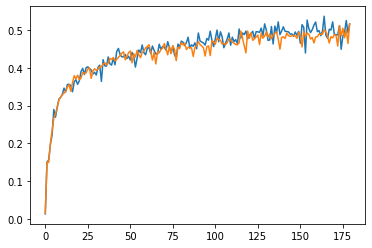

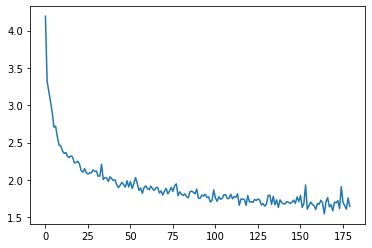

In [36]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()
plt.figure()
plt.plot(record['loss'])
plt.show()

In [26]:
print(generate(model, device, seed='I will'))

I will end how as but you the duke.
When you the hould be you to his counder:
Thy sail of dear are here!

First Carriunt:
My lack, and lorson set her deed take for
be shall yeid! I did be wear you are sad him,
This divers in our child and good rejeate,
Tha


In [35]:
print(generate(model, device, seed='I will', predict_len=500))

I will the will to the lake to mistress,
That I was to my contone one, my lord
To mound to the with to my scalles.

IATANIO:
As that Caled deselve.

OINA:
So like, the rether way state the
charse sitton recelome! Veresount, country.

First Gentream:
Who's thee. There quees, not the world with to company to
not when to I such his basland of the ender, he
coust in the grace you wing a hisplent,
For I with but do not must be the party:
And we on the essence, sir, but the agours my more offern?

MOSTERSES
